In [10]:
# The CPI measures the change in the cost of living from one period to the next. 
# Household spending weights are used to average the changes in component goods and services into the All-items index.
# This notebook use the data retreived from FRED to study the inflation rate(%) across all items, Food, Energy and items less food and energy.
# It also shows the RI ratios that indicates how the index population distributes expenditures among the components and the % of each 
# component use to calculate the CPI.
    
# Dependencies
import json
import requests
import pprint as pp
from config import fred_api_key
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date
import plotly.express as px
import numpy as np
import plotly.graph_objs as go
import plotly.offline as pyo

In [11]:
#Retrieve observations from FRED using the series id and date range provided to the method call. 
def getFredObservationsBySeries(series_id, observation_start, observation_end):
    print(f"Getting Data for Series ID {series_id} Start Date {observation_start} End Date {observation_end}")
    url = "https://api.stlouisfed.org/fred/series/observations"
    #geo_fred_url = "https://api.stlouisfed.org/geofred/series/observations"
    params = {
        "series_id": series_id,
        "observation_start": observation_start,
        "observation_end": observation_end,
        "api_key": fred_api_key,
        "file_type": "json"
    }
    # Fetch data
    response = requests.get(url, params=params)
    data = response.json()
    # pp.pprint(data)
    # Read the dataset inside data dict using key 'observations'
    observations = data['observations']
    observations_df = pd.DataFrame(observations)
    # Print the structure of the observations DF
    print(f"Observation DF Data Types {observations_df.info()}")
    # Rename columns
    observations_df.rename(columns={
    'value': 'Value',
    'date': 'Date'
    }, inplace=True)
    print(f"Observation Table {observations_df.columns}")
    #Convert the date column data type to datetime and set it as index
    observations_df['Date'] = pd.to_datetime(observations_df['Date'])
    observations_df.set_index('Date', inplace=True)
    # Create a year column using the Date 
    observations_df['Year'] = observations_df.index.year
    observations_df['Value'] = observations_df['Value'].astype(float)    
    #calculate the inflation rate over 12 month period
    observations_df['Inflation Rate'] = round(observations_df['Value'].pct_change(periods=12) * 100,2)
    # Average Annual Inflation %
    observations_df['Avg Annual Inflation Rate'] = round(observations_df['Inflation Rate'].mean(),2)
    # print(observations_df.head(10))
    # Drop rows with NaN values in column 'Inflation Rate'
    observations_df_cleaned = observations_df.dropna(subset=['Inflation Rate'])
    print(observations_df_cleaned.head(10))
    return observations_df_cleaned
    



In [30]:
#Get Relative importance of components in the Consumer Price Indexes: U.S. city average, December 2023

# For all regions
def readRIByRegion(file_path):
    ri_all_region_df = pd.read_csv(file_path) 
    
    # Dropn NaN values in the Indent Level Column
    ri_all_region_df = ri_all_region_df.dropna(subset=['Indent Level'])
    
    # Change the Indent column to Int
    ri_all_region_df['Indent Level'] = ri_all_region_df['Indent Level'].astype(int)
    print(ri_all_region_df.info())
    print(ri_all_region_df.head(5))
    return ri_all_region_df

# For all components
def readRIForAllComponents(file_path):
    ri_all_category_df = pd.read_csv(file_path) 
    
    # Dropn NaN values in the Indent Level Column
    ri_all_category_df = ri_all_category_df.dropna(subset=['Indent Level'])
    
    # Change the Indent column to Int
    ri_all_category_df['Indent Level'] = ri_all_category_df['Indent Level'].astype(int)
    print(ri_all_category_df.info())
    print(ri_all_category_df.head(5))
    return ri_all_category_df

#  For Main All Items components
def readRIForMainComponents(ri_all_category_df):
    #Anything after 'Special aggregate indexes' Item Group can be discarded
    special_category = ri_all_category_df.loc[ri_all_category_df['Item and Group'] == 'Special aggregate indexes'].iloc[0]
    special_category_index = special_category.name
    print(f"Special Category Index Value : {special_category_index }")
    
    #Get the RI for main categories with Indent Level 1 and less than the special category index
    ri_main_category_df = ri_all_category_df[
    (ri_all_category_df['Indent Level'] == 1) &
    (ri_all_category_df.index < special_category_index)]
    print(f"Main Categories used for CPI calculation ")
    print(ri_main_category_df.head(10))
    return ri_main_category_df
 
#Provide a dict with main component as the key and its child components data in a DF
def readRIForComponentsInMain(ri_main_category_df, ri_all_category_df):
     subcategories_dfs = {}    
     #Anything after 'Special aggregate indexes' Item Group can be discarded
     special_category = ri_all_category_df.loc[ri_all_category_df['Item and Group'] == 'Special aggregate indexes'].iloc[0]
     special_category_index = special_category.name
     print(f"Special Category Index Value : {special_category_index }")
     # Get the subcategories
     for i in range(0, len(ri_main_category_df)) :
            category_name = ri_main_category_df.iloc[i]['Item and Group']
            start_range = ri_main_category_df.index[i]
            if i+1 == len(ri_main_category_df):
                end_range = special_category_index
            else:
                end_range = ri_main_category_df.index[i+1]
            print(f"Subcategory for {category_name} with Range {start_range} {end_range}")
            # Get all the subcategories information for a main category
            ri_subcategories_df = ri_all_category_df.loc[(ri_all_category_df.index > start_range) & (ri_all_category_df.index < end_range)]
            if category_name == 'Food and beverages':
                indent_level = 6
            else:
                indent_level = 2
            ri_subcategories_df = ri_subcategories_df.loc[(ri_subcategories_df['Indent Level'] == indent_level)]
            subcategories_dfs[category_name] = ri_subcategories_df
            print(f"{subcategories_dfs[category_name]}")
        
     return subcategories_dfs
    
# Create Pie Chart to display - Relative importance of components in the Consumer Price Indexes: U.S. city average, December 2023
def createPieChartForMainComponents(ri_main_category_df, write_html_file_name):    
    fig = px.pie(ri_main_category_df, 
                 values= 'Values', 
                 names='Item and Group', 
                 title='Relative Importance of CPI-U by Category',
                 color_discrete_sequence=px.colors.sequential.RdBu)
    
    fig.update_traces(hovertemplate='%{label}: <b>%{value}</b>')
    
    fig.update_layout(
        height=600,  # Height of the figure in pixels
        width=500,   # Width of the figure in pixels
        margin=dict(t=0, b=0, l=0, r=0)  # Reduce the margins
    )
    
    fig.show()    
    fig.write_html(f"{write_html_file_name}.html")

#Create the pie charts for all the child components
def createPieChartForChildComponents(sub_categories_df, write_html_file_name):
    for key, sub_categories_df in subcategories_dfs.items():
        # There's multiple sub-categories so lets just display first 10 with most weightage in its category 
        sorted_sub_categories_df = sub_categories_df.sort_values('Values', ascending=False).head(10)
        # fig = px.pie(sorted_sub_categories_df, values='Values', names='Item and Group', 
        #               title= 'Relative Importance of CPI-U by Category')
        fig = px.sunburst(sub_categories_df, path=['Indent Level', 'Item and Group'], values='Values')
        fig.update_traces(hovertemplate='%{label}: <b>%{value}</b>')
        fig.update_layout(
            height=600,  # Height of the figure in pixels
            width=375,   # Width of the figure in pixels
            margin=dict(t=0, b=0, l=0, r=0)  # Reduce the margins
        )
        fig.show()
        fig.write_html(f"{write_html_file_name}_{key}.html")

In [16]:
# Retrieve the weightage of different components for all cities recorded in DEC 2023
ri_all_city_file_path = "Resources\RI_CPI-U_2023.csv" 

ri_all_category_df = readRIForAllComponents(ri_all_city_file_path)

ri_main_category_df = readRIForMainComponents(ri_all_category_df)

subcategories_dfs = readRIForComponentsInMain(ri_main_category_df,ri_all_category_df)



<class 'pandas.core.frame.DataFrame'>
Index: 324 entries, 0 to 333
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Indent Level              324 non-null    int32  
 1   Item and Group            324 non-null    object 
 2   U.S. City Average(CPI-U)  322 non-null    float64
 3   U.S. City Average(CPI-W)  322 non-null    float64
dtypes: float64(2), int32(1), object(1)
memory usage: 11.4+ KB
None
   Indent Level        Item and Group  U.S. City Average(CPI-U)  \
0             0  Expenditure category                       NaN   
1             0             All items                   100.000   
2             1    Food and beverages                    14.409   
3             2                  Food                    13.555   
4             3          Food at home                     8.167   

   U.S. City Average(CPI-W)  
0                       NaN  
1                   100.000  
2         

C:\Users\boseb\AppData\Local\Temp\ipykernel_13400\495225995.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



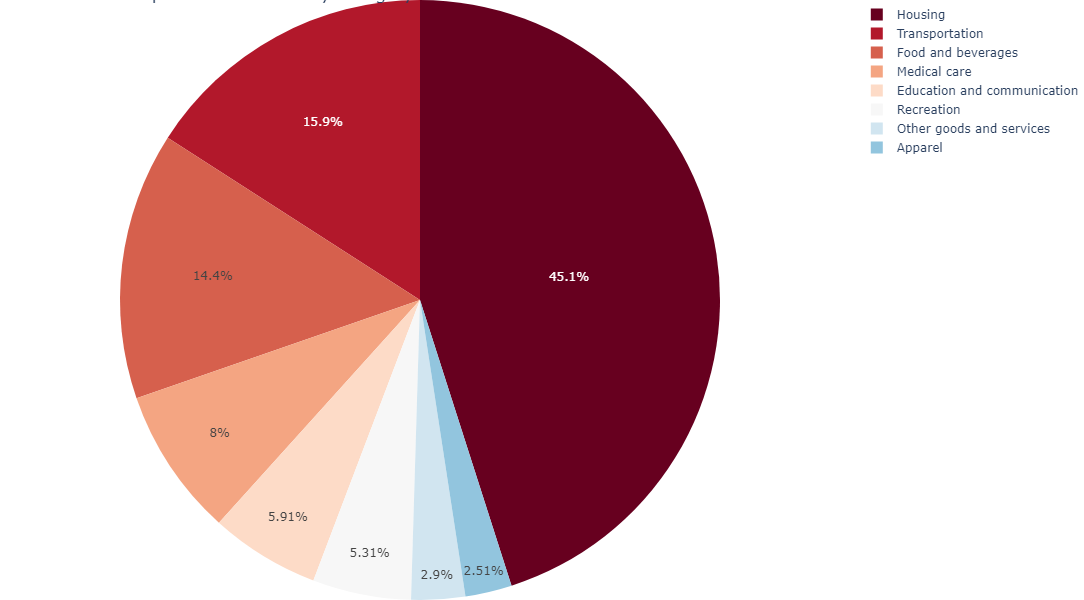

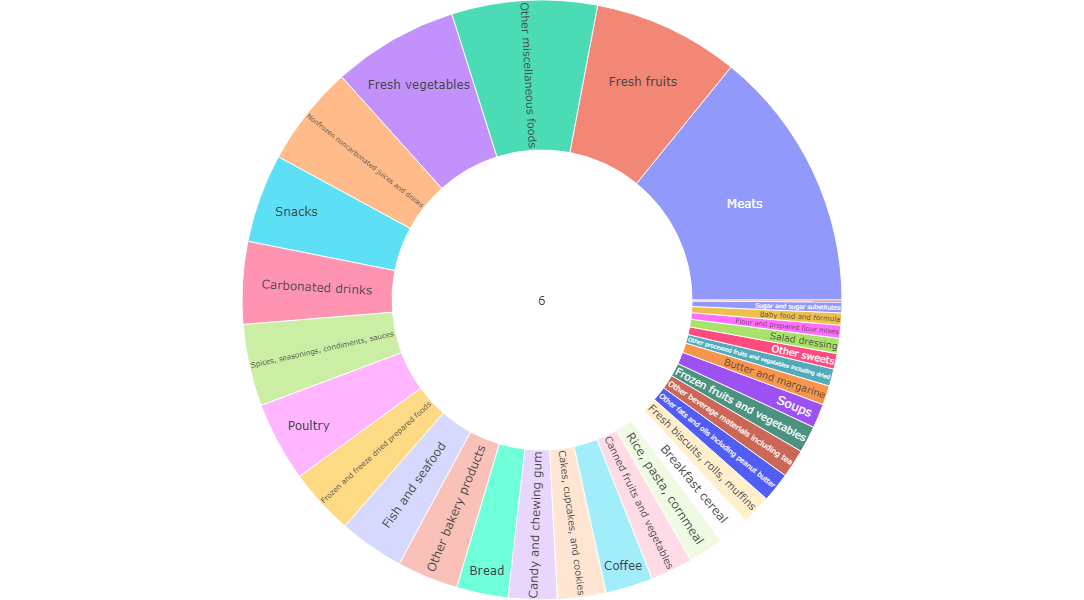

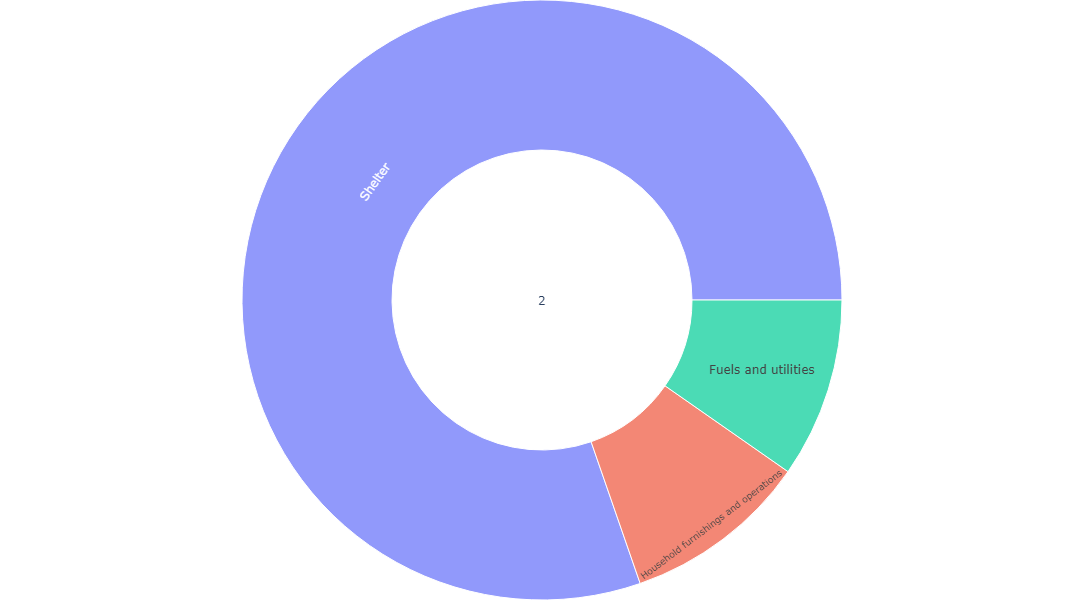

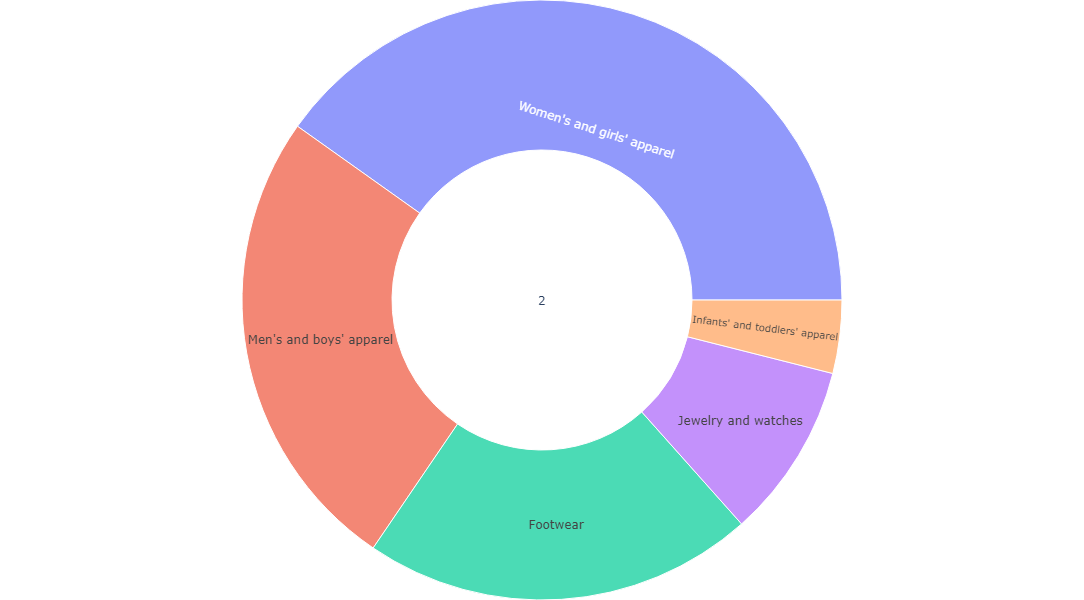

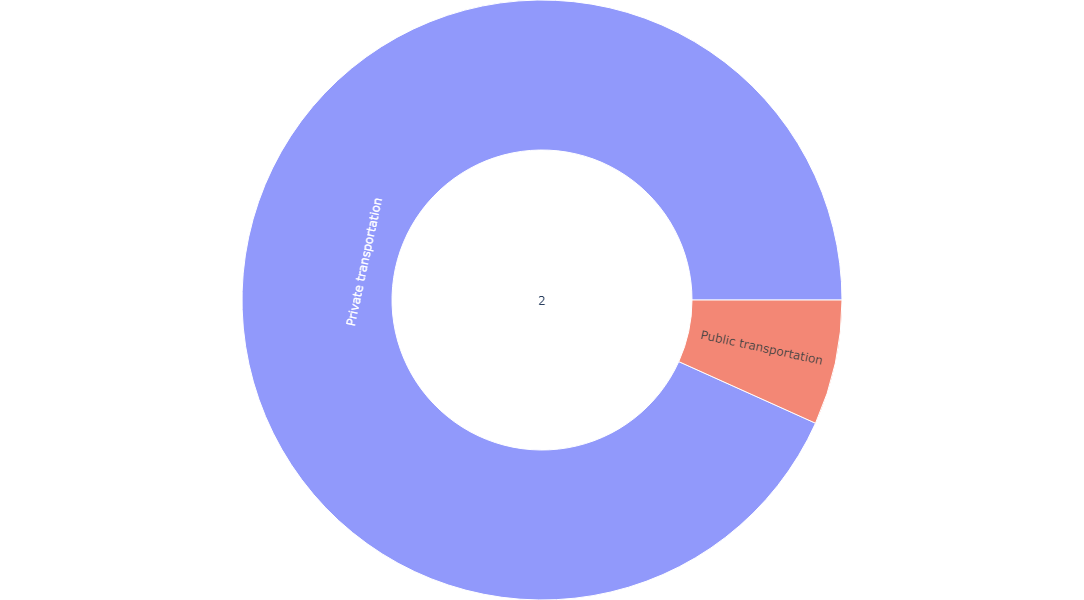

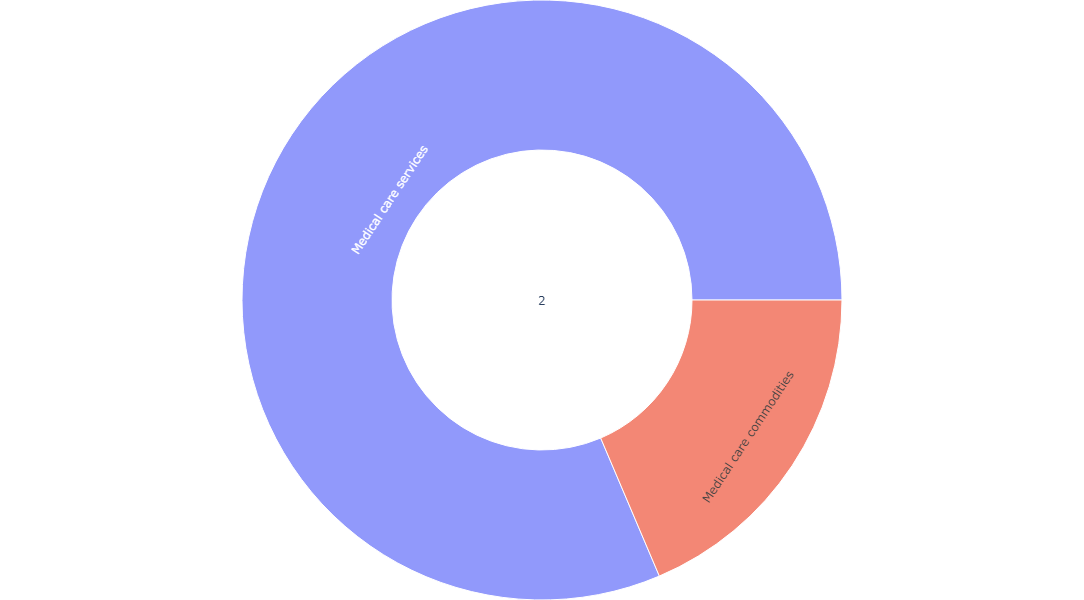

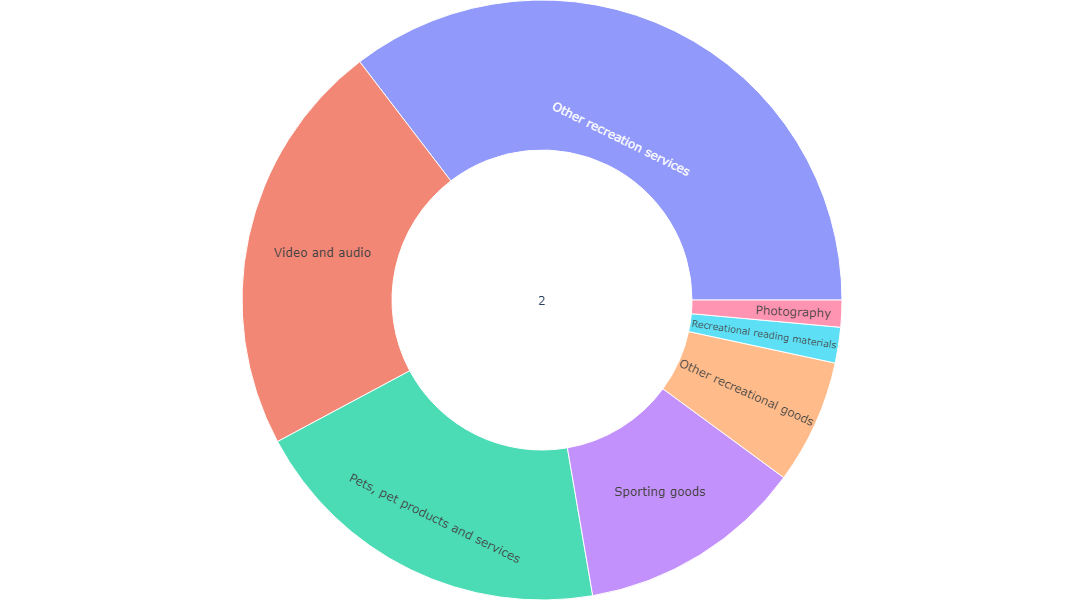

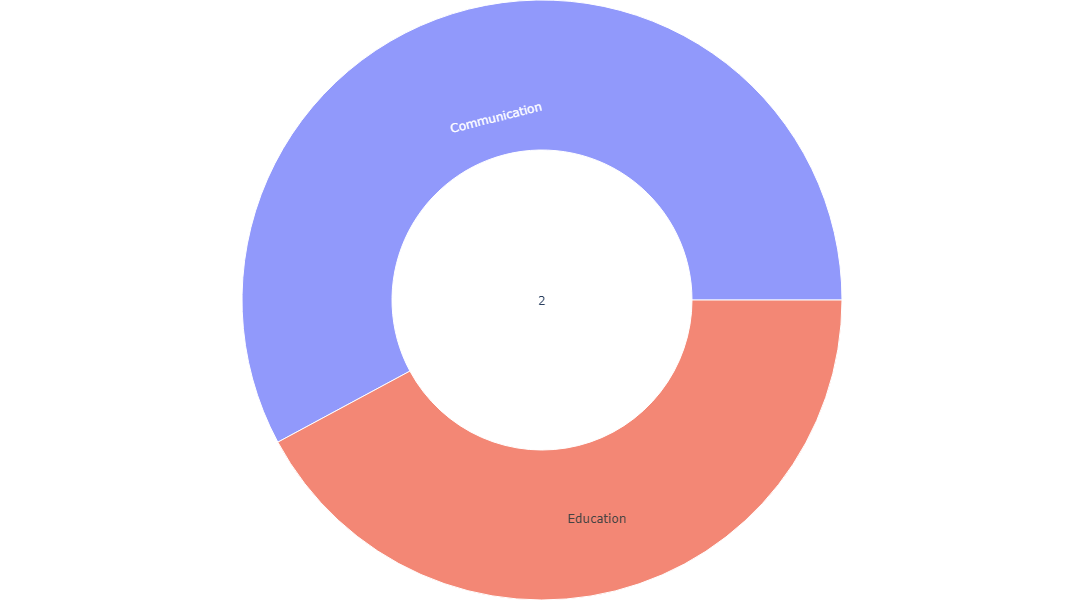

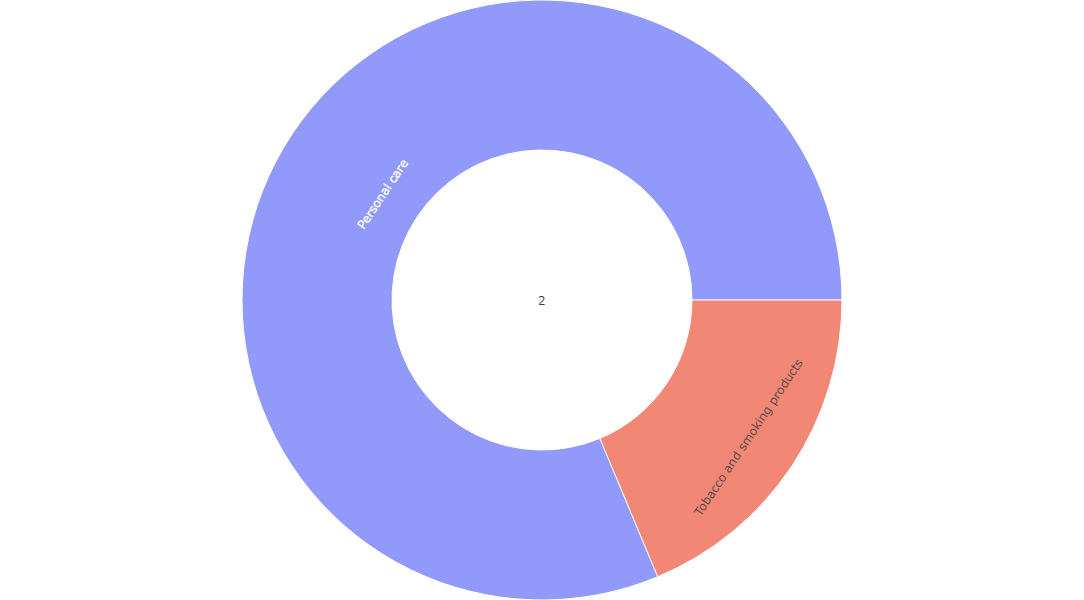

In [31]:
# Create the pie chart to display the weightage of different components and it's sub-components for all cities recorded in DEC 2023
ri_main_category_df.rename(columns={'U.S. City Average(CPI-U)':'Values'}, inplace=True)
createPieChartForMainComponents(ri_main_category_df, "2023_RI_all_cities")

for key, sub_categories_df in subcategories_dfs.items():
    sub_categories_df.rename(columns={'U.S. City Average(CPI-U)':'Values'}, inplace=True)
createPieChartForChildComponents(subcategories_dfs, "2023_RI_all_cities")


<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 2 to 22
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Indent Level  21 non-null     int32  
 1   Area          21 non-null     object 
 2   CPI-U         21 non-null     float64
 3   CPI-W         21 non-null     float64
dtypes: float64(2), int32(1), object(1)
memory usage: 756.0+ bytes
None
   Indent Level                        Area   CPI-U   CPI-W
2             0                   Northeast  19.016  16.720
3             1    Northeast - Size Class A   9.636   8.892
4             1  Northeast - Size Class B/C   9.380   7.828
5             1              New England(2)   5.678   4.567
6             1          Middle Atlantic(2)  13.337  12.153


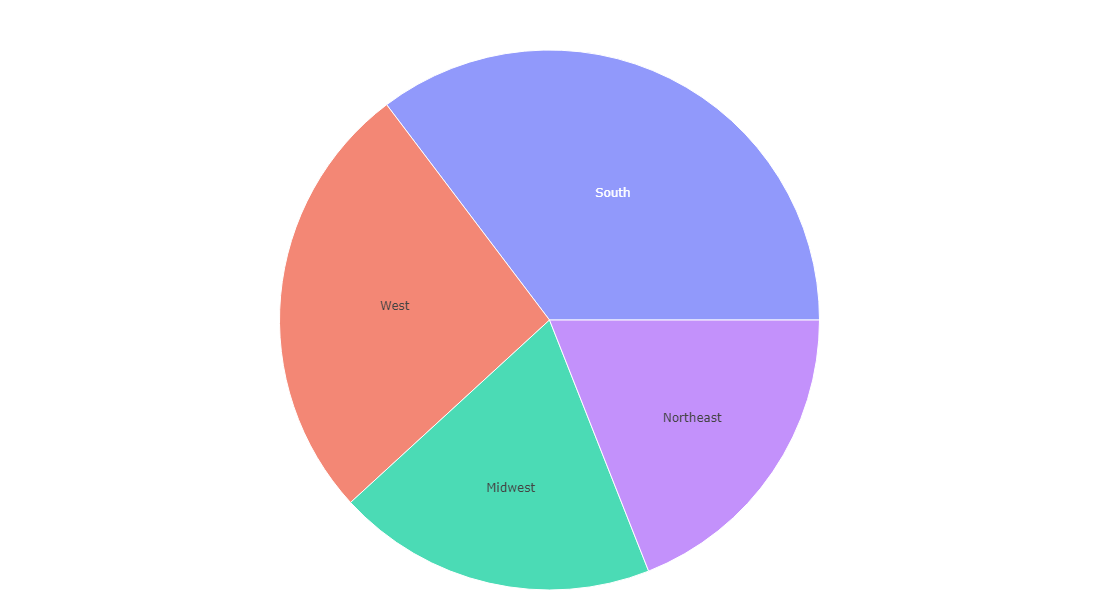

In [32]:
# Retrieve the weightage of different components for major regions recorded in DEC 2023

ri_by_region_pop_file_path = "Resources\RI_By_Region_Population_CPI-U_2023.csv"

ri_all_region_df = readRIByRegion(ri_by_region_pop_file_path)

ri_north_df = ri_all_region_df[ri_all_region_df['Indent Level'] == 0]

# Create the pie chart of the weightage of different components for major regions recorded in DEC 2023

fig = px.sunburst(ri_north_df, path=['Area'], values='CPI-U')

fig.update_traces(hovertemplate='%{label}: <b>%{value}</b>')

fig.update_layout(
    height=600,  # Height of the figure in pixels
    width=400,   # Width of the figure in pixels
    margin=dict(t=50, b=10, l=1, r=3)  # Reduce the margins
)
fig.show()
fig.write_html("2023_RI_Major_Cities.html")

In [19]:
# Set the Series id and date ranges for fetching the data from FRED API


#Use FRED API to fetch the Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (Seasonally Adjusted)
cpi_urban_city_av_seasonal = 'CPIAUCSL'
#Use FRED API to fetch the Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (Not Seasonally Adjusted)
cpi_urban_city_av_not_seasonal = 'CPIAUCNS'
#Use FRED API to fetch the Consumer Price Index for All Urban Consumers : All Items less Food and Energy U.S. City Average (Seasonally Adjusted)
cpi_urban_exclude_food_energy_sl = 'CPILFESL'
#Use FRED API to fetch the Consumer Price Index for All Urban Consumers : All Items less Food and Energy U.S. City Average (Not Seasonally Adjusted)
cpi_urban_exclude_food_energy_ns = 'CPILFENS'
#Use FRED API to fetch the Consumer Price Index for All Urban Consumers: Energy in U.S. City Average (Seasonally Adjusted)
cpi_urban_city_energy_sl = 'CPIENGSL'
#Use FRED API to fetch the Consumer Price Index for All Urban Consumers: Food in U.S. City Average (Seasonally Adjusted)
cpi_urban_city_food_sl = 'CPIUFDSL' 

ten_year_start_date = "2013-08-04"

covid_year_start_date = "2020-01-01"

russia_ukraine_war = "2022-02-01"

# Calculating Todays Date
now = datetime.now()
now_iso_format = date(now.year,now.month,now.day).isoformat()
print("Current date and time:", now_iso_format)


Current date and time: 2024-08-12


In [20]:
# Retrieve the Consumer Price Index for All Urban Consumers for different categories from FRED API

observations_au_sl_df = getFredObservationsBySeries(cpi_urban_city_av_seasonal,ten_year_start_date,now_iso_format)
observations_au_ns_df = getFredObservationsBySeries(cpi_urban_city_av_not_seasonal,ten_year_start_date,now_iso_format)
observations_lfe_sl_df = getFredObservationsBySeries(cpi_urban_exclude_food_energy_sl,ten_year_start_date,now_iso_format)
observations_lfe_ns_df = getFredObservationsBySeries(cpi_urban_exclude_food_energy_ns,ten_year_start_date,now_iso_format)
observations_energy_sl_df = getFredObservationsBySeries(cpi_urban_city_energy_sl,ten_year_start_date,now_iso_format)
observations_food_sl_df = getFredObservationsBySeries(cpi_urban_city_food_sl,ten_year_start_date,now_iso_format)
print("*********************************************************************************")
print("Consumer Price Index for All Urban Consumers Seasonally Adjusted")
print("*********************************************************************************")
print(observations_au_sl_df.head())
print("*********************************************************************************")
print("Consumer Price Index for All Urban Consumers Not Seasonally Adjusted")
print("*********************************************************************************")
print(observations_au_ns_df.head())
print("*********************************************************************************")
print("Consumer Price Index for All Less food and Energy Seasonally Adjusted")
print("*********************************************************************************")
print(observations_lfe_sl_df.head())
print("*********************************************************************************")
print("Consumer Price Index for All Less food and Energy not Seasonally Adjusted")
print("*********************************************************************************")
print(observations_lfe_ns_df.head())
print("*********************************************************************************")
print("Consumer Price Index for All Energy Seasonally Adjusted")
print("*********************************************************************************")
print(observations_energy_sl_df.head())
print("*********************************************************************************")
print("Consumer Price Index for All Food Seasonally Adjusted")
print("*********************************************************************************")
print(observations_food_sl_df.head())


Getting Data for Series ID CPIAUCSL Start Date 2013-08-04 End Date 2024-08-12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   realtime_start  131 non-null    object
 1   realtime_end    131 non-null    object
 2   date            131 non-null    object
 3   value           131 non-null    object
dtypes: object(4)
memory usage: 4.2+ KB
Observation DF Data Types None
Observation Table Index(['realtime_start', 'realtime_end', 'Date', 'Value'], dtype='object')
           realtime_start realtime_end    Value  Year  Inflation Rate  \
Date                                                                    
2014-08-01     2024-08-12   2024-08-12  237.460  2014            1.72   
2014-09-01     2024-08-12   2024-08-12  237.477  2014            1.68   
2014-10-01     2024-08-12   2024-08-12  237.430  2014            1.61   
2014-11-01     2024-08-12

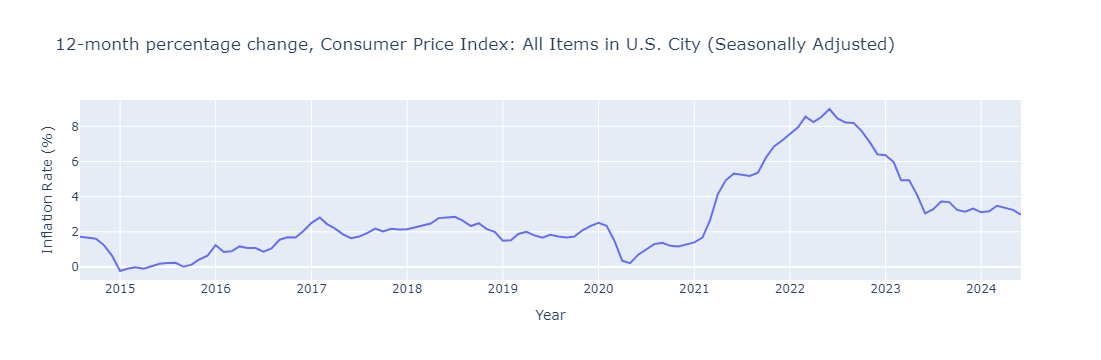

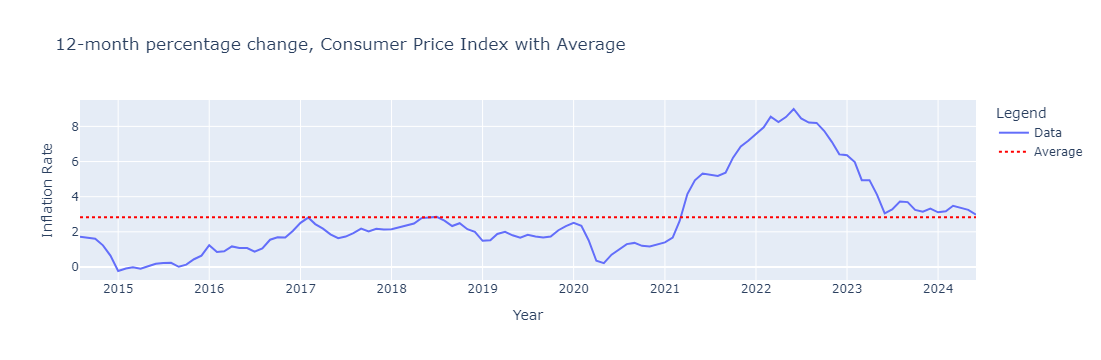

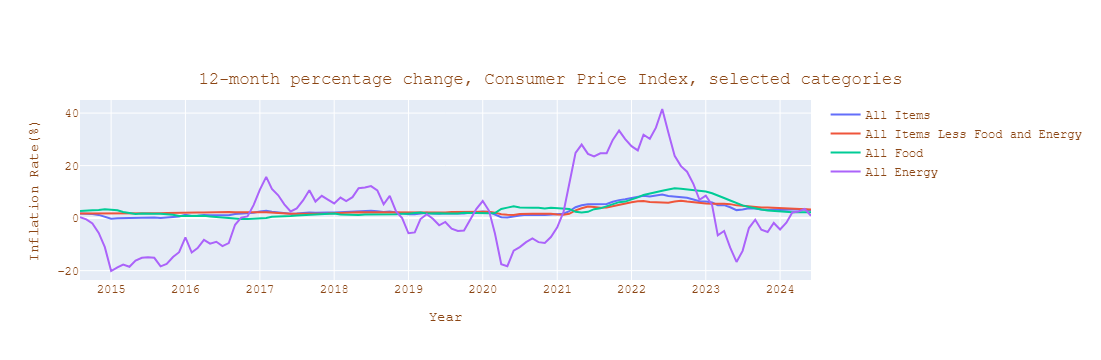

In [21]:

#Create interactive map using plotly

# Plot the inflation rate change in CPI (Consumer Price Index for All Items in USA)

fig = px.line(
    observations_au_sl_df, 
    x=observations_au_sl_df.index, 
    y=observations_au_sl_df['Inflation Rate'],    
    title="12-month percentage change, Consumer Price Index: All Items in U.S. City (Seasonally Adjusted)",
    labels={"Date": "Year", "Inflation Rate": "Inflation Rate (%)"})
fig.show()

fig.write_html("2023_CPI_Change_ALL_Items.html")

average_value = observations_au_sl_df['Inflation Rate'].mean()

# Create the initial time graph
fig = go.Figure(go.Scatter(x=observations_au_sl_df.index, y=observations_au_sl_df['Inflation Rate'], mode='lines', name='Data'))

# Add a dotted line for the average
fig.add_trace(go.Scatter(x=observations_au_sl_df.index, y=[average_value]*len(observations_au_sl_df), mode='lines', name='Average',
                         line=dict(color='red', width=2, dash='dot')))

# Customize the layout
fig.update_layout(title='12-month percentage change, Consumer Price Index with Average',
                  xaxis_title='Year',
                  yaxis_title='Inflation Rate',
                  legend_title='Legend')

# Show the figure
fig.show()
fig.write_html("2023_CPI_Avg_Change_ALL_Items.html")

# Plot the inflation rate change in CPI for All Items in USA, Food, Energy and Items Less Food and Energy
fig = go.Figure()

# Add traces for each time series
fig.add_trace(go.Scatter(x=observations_au_sl_df.index, y=observations_au_sl_df['Inflation Rate'], mode='lines', name='All Items'))
fig.add_trace(go.Scatter(x=observations_lfe_sl_df.index, y=observations_lfe_sl_df['Inflation Rate'], mode='lines', name='All Items Less Food and Energy'))
fig.add_trace(go.Scatter(x=observations_food_sl_df.index, y=observations_food_sl_df['Inflation Rate'], mode='lines', name='All Food'))
fig.add_trace(go.Scatter(x=observations_energy_sl_df.index, y=observations_energy_sl_df['Inflation Rate'], mode='lines', name='All Energy'))

fig.update_layout(
    title={
        'text': '12-month percentage change, Consumer Price Index, selected categories',
        'y':0.8,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Year',
    yaxis_title='Inflation Rate(%)',
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="saddlebrown"
    )
)

# Show the figure
fig.show()
fig.write_html("2023_CPI_Change_Diff_Categories.html")